In [1]:
import torch
import torchvision.models as models
import numpy as np
from tqdm import tqdm
import matplotlib.pylab as plt
from insilico_Exp_torch import TorchScorer
from GAN_utils import upconvGAN
from ZO_HessAware_Optimizers import CholeskyCMAES
from layer_hook_utils import get_module_names, register_hook_by_module_names, layername_dict

First prepare our network models. 

In [2]:
G = upconvGAN("fc6").cuda()
G.requires_grad_(False)
scorer = TorchScorer("resnet50")
module_names, module_types, module_spec = get_module_names(scorer.model, input_size=(3, 227, 227), device="cuda");
# scorer = TorchScorer("vgg16")
# scorer.select_unit(("vgg16", "fc2", 10, 10, 10))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


------------------------------------------------------------------------------
      Layer Id       inshape       outshape           Type                 ReadableStr 
        0        (3, 227, 227) (3, 227, 227)           Input                      Image
        1        (3, 227, 227) (64, 114, 114)          Conv2d               .Conv2dconv1
        2        (64, 114, 114) (64, 114, 114)     BatchNorm2d            .BatchNorm2dbn1
        3        (64, 114, 114) (64, 114, 114)            ReLU                  .ReLUrelu
        4        (64, 114, 114) (64, 57, 57)       MaxPool2d          .MaxPool2dmaxpool
        5        (64, 57, 57) (64, 57, 57)          Conv2d      .layer1.0.Conv2dconv1
        6        (64, 57, 57) (64, 57, 57)     BatchNorm2d   .layer1.0.BatchNorm2dbn1
        7        (64, 57, 57) (64, 57, 57)            ReLU         .layer1.0.ReLUrelu
        8        (64, 57, 57) (64, 57, 57)          Conv2d      .layer1.0.Conv2dconv2
        9        (64, 57, 57) (64, 57, 57)  

Next load up machineries from visual neuron modelling package. 

In [3]:
import sys
sys.path.append(r"D:\Github\Visual_Neuron_Modelling")
from CorrFeatTsr_lib import Corr_Feat_Machine
from featvis_lib import load_featnet, rectify_tsr, tsr_posneg_factorize
from CorrFeatTsr_visualize_lib import CorrFeatScore

In [4]:
def score_images(featNet, scorer, layername, imgtsr, preprocessor=lambda x:x, batchsize=40,):
    """ Basic function to use scorers to load and score a bunch of imgfps. 
    :param featNet: a feature processing network nn.Module.
    :param scorer: CorrFeatScore
    :param layername: str, the layer you are generating the score from
    :param imgfps: a list of full paths to the images.
    :param imgloader: image loader, a function taking a list to full path as input and returns a preprocessed image
        tensor.
    :param batchsize: batch size in processing images. Usually 120 is fine with a 6gb gpu.
    :return:
        score_all: tensor of returned scores.

    :Example:
        scorer = CorrFeatScore()
        scorer.register_hooks(net, layer, netname=netname)
        scorer.register_weights({layer: DR_Wtsr})
        pred_score = score_images(featnet, scorer, layer, imgfullpath_vect, imgloader=loadimg_preprocess, batchsize=80,)
        scorer.clear_hook()
        nlfunc, popt, pcov, scaling, nlpred_score = fitnl_predscore(pred_score.numpy(), score_vect)

    """
    imgN = imgtsr.shape[0]
    csr = 0
    pbar = tqdm(total=imgN)
    score_all = []
    while csr < imgN:
        cend = min(csr + batchsize, imgN)
        input_tsr = preprocessor(imgtsr[csr:cend,:,:,:])  # imgpix=120, fullimgsz=224, borderblur=True
        with torch.no_grad():
            featNet(input_tsr.cuda()).cpu()
            score = scorer.corrfeat_score(layername)
        score_all.append(score.detach().clone().cpu())
        pbar.update(cend - csr)
        csr = cend
    pbar.close()
    score_all = torch.cat(tuple(score_all), dim=0)
    return score_all

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
layer = ".layer4.Bottleneck0"
chan = 10
layer_key = [k for k, v in module_names.items() if v == layer][0]
feat_outshape = module_spec[layer_key]['outshape']
assert len(feat_outshape) == 3  # fc layer will fail
cent_pos = (feat_outshape[1]//2, feat_outshape[2]//2)
print("Center position on the feature map is (%d %d) of layer %s (tensor shape %s)"%(*cent_pos,layer,feat_outshape))
# scorer.select_unit(("resnet50", layer, chan, *cent_pos), allow_grad=True)

Center position on the feature map is (4 4) of layer .layer4.Bottleneck0 (tensor shape (2048, 8, 8))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Target neuron network 
scorer = TorchScorer("resnet50")
scorer.select_unit(("resnet50", layer, 5, 5, 5), allow_grad=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Model Network
VGG = models.vgg16(pretrained=True)
VGG.requires_grad_(False).eval()
VGG.features.cuda()
# Multi-case modelling 
featFetcher = Corr_Feat_Machine()
featFetcher.register_hooks(VGG, ["conv2_2", "conv3_3","conv4_3", "conv5_3"], netname='vgg16', verbose=False)
featFetcher.init_corr()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
for i in tqdm(range(50)):
    imgs = G.visualize(torch.randn(40,4096).cuda())
    resp = scorer.score_tsr_wgrad(imgs, B=40)
    with torch.no_grad():
        VGG.features(imgs)
    del imgs
    featFetcher.update_corr(resp.cpu())

featFetcher.calc_corr()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 640.00 MiB (GPU 0; 6.00 GiB total capacity; 2.40 GiB already allocated; 378.38 MiB free; 3.46 GiB reserved in total by PyTorch)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


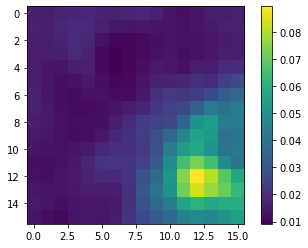

In [10]:
plt.imshow(featFetcher.cctsr['conv5_3'].abs().mean(dim=0))
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


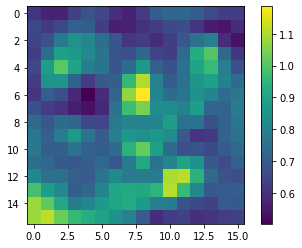

In [31]:
plt.imshow(np.abs(Ttsr).mean(axis=0))
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity after T threshold 0.235
NMF explained variance 0.443
Factor0 norm 5.33
Factor1 norm 4.16
Factor2 norm 3.50
Correlation to the corr coef tensor 0.805


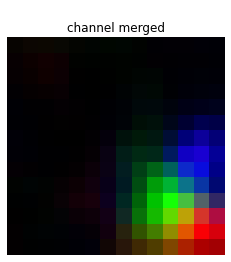

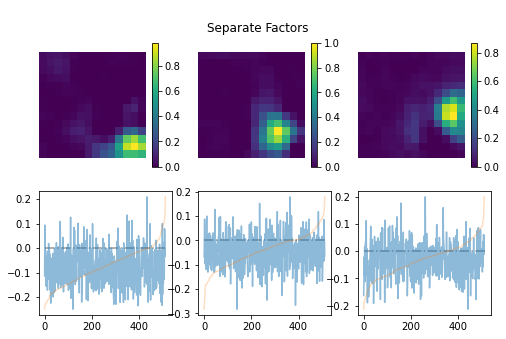

In [11]:
cctsr = featFetcher.cctsr['conv5_3'].numpy()
Ttsr = featFetcher.Ttsr['conv5_3'].numpy()
rect_mode = "Tthresh"; thresh = (-2, 2)
bdr = 1; NF = 3
Hmat, Hmaps, ccfactor, FactStat = tsr_posneg_factorize(rectify_tsr(cctsr, rect_mode, thresh, Ttsr=Ttsr),
                     bdr=bdr, Nfactor=NF, show=True,)

Sparsity after T threshold 0.002
NMF explained variance 0.423
Factor0 norm 0.41
Factor1 norm 0.52
Factor2 norm 0.40
Factor3 norm 0.31
Factor4 norm 0.27
Correlation to the corr coef tensor 0.816


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


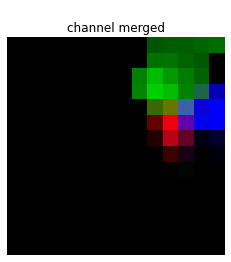

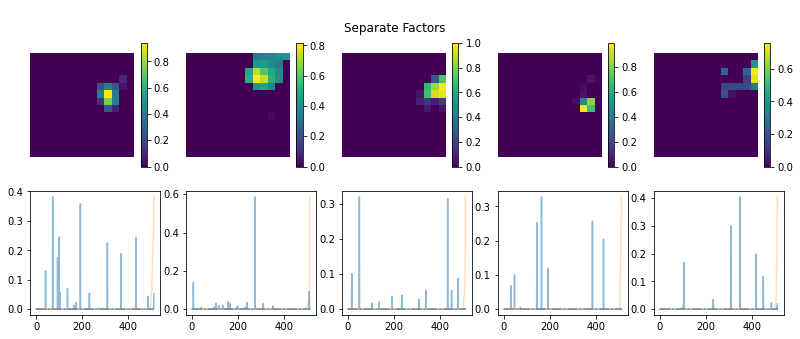

In [32]:
cctsr = featFetcher.cctsr['conv5_3'].numpy()
Ttsr = featFetcher.Ttsr['conv5_3'].numpy()
rect_mode = "Tthresh"; thresh = (None, 5)
bdr = 1; NF = 5
Hmat, Hmaps, ccfactor, FactStat = tsr_posneg_factorize(rectify_tsr(cctsr, rect_mode, thresh, Ttsr=Ttsr),
                     bdr=bdr, Nfactor=NF, show=True,)

Sparsity after T threshold 0.176
NMF explained variance 0.251
Factor0 norm 1.71
Factor1 norm 1.39
Factor2 norm 1.27
Predictability of the corr coef tensor 0.675


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


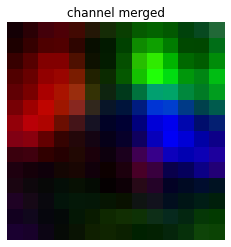

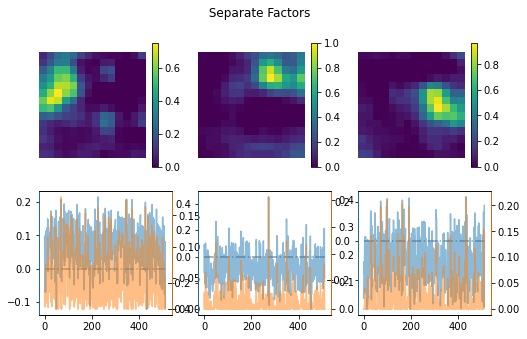

(array([[0.03030812, 0.        , 0.00832545],
        [0.06367926, 0.        , 0.0087316 ],
        [0.10006683, 0.        , 0.01544208],
        [0.11481267, 0.        , 0.00932776],
        [0.09822372, 0.01378551, 0.00396773],
        [0.05398016, 0.03415877, 0.00999234],
        [0.031721  , 0.06534392, 0.00893798],
        [0.01378691, 0.0923235 , 0.00161012],
        [0.00805533, 0.1344424 , 0.        ],
        [0.00522628, 0.14699627, 0.        ],
        [0.00370796, 0.13073067, 0.00173703],
        [0.        , 0.09853644, 0.01692281],
        [0.01081227, 0.10905803, 0.04842342],
        [0.04898953, 0.15549722, 0.08275552],
        [0.04312215, 0.        , 0.        ],
        [0.07880486, 0.        , 0.        ],
        [0.11644247, 0.        , 0.        ],
        [0.1205911 , 0.        , 0.        ],
        [0.06866397, 0.00794371, 0.        ],
        [0.01289567, 0.02098927, 0.        ],
        [0.00339149, 0.03996951, 0.        ],
        [0.00091814, 0.09733552, 0

In [21]:
Ctsr = rectify_tsr(featFetcher.cctsr['conv5_3'].numpy(), mode="Tthresh", Ttsr=featFetcher.Ttsr['conv5_3'].numpy(), thr=(None,1))
tsr_factorize(Ttsr_pp=Ctsr, \
              cctsr=featFetcher.cctsr['conv5_3'].numpy(),bdr=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


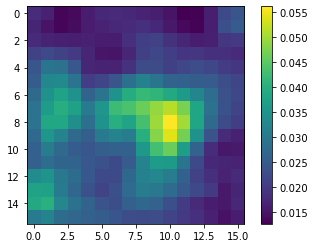

In [61]:
plt.imshow(featFetcher.cctsr['conv5_3'].abs().mean(dim=0))
plt.colorbar()
plt.show()

In [134]:
cctsr_rect = rectify_tsr(featFetcher.cctsr['conv5_3'].numpy(),mode="Tthresh",thr=(-1,1),Ttsr=featFetcher.Ttsr['conv5_3'].numpy())

Sparsity after T threshold 0.343


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


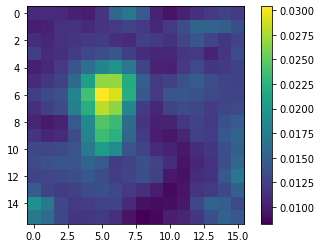

In [137]:
plt.imshow(featFetcher.cctsr['conv5_3'].abs().mean(axis=0))
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


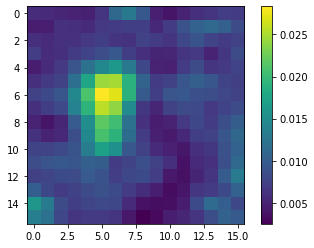

In [138]:
plt.imshow(np.abs(cctsr_rect).mean(axis=0))
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


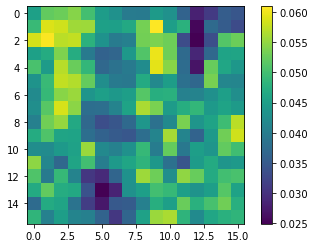

In [146]:
val,idx = featFetcher.cctsr['conv5_3'].max(dim=0)
plt.imshow(val)
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


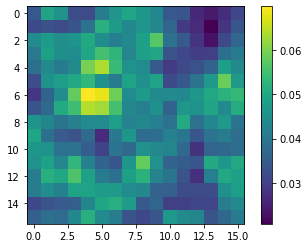

In [118]:
val,idx = featFetcher.cctsr['conv5_3'].max(dim=0)
plt.imshow(val)
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


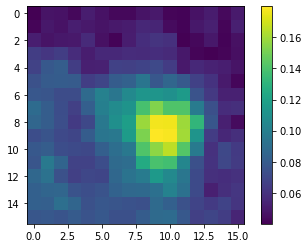

In [69]:
val,idx = featFetcher.cctsr['conv5_3'].abs().max(dim=0)
plt.imshow(val)
plt.colorbar()
plt.show()

In [71]:
featFetcher.make_savedict()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'imgN': 4000,
 'cctsr': {'conv2_2': array([[[-0.01262933, -0.00769246, -0.00312021, ...,  0.01272087,
            0.01645167,  0.01181934],
          [-0.0033672 ,  0.00152495,  0.00442768, ...,  0.00822709,
            0.00865363,  0.01057853],
          [ 0.00078087,  0.00316709, -0.00348765, ...,  0.00366532,
            0.00415016,  0.00613826],
          ...,
          [ 0.00542094,  0.01222924,  0.01795257, ..., -0.01776813,
           -0.00910671,  0.00239501],
          [ 0.01767125,  0.01749677,  0.01680193, ..., -0.00779276,
           -0.00275217,  0.00084066],
          [ 0.0201048 ,  0.01087787, -0.00765633, ..., -0.0097335 ,
           -0.00484536,  0.0010813 ]],
  
         [[ 0.00224432, -0.00847626,  0.0003935 , ...,  0.00930325,
           -0.00676363, -0.0157921 ],
          [-0.01406547, -0.01105892, -0.00281648, ...,  0.0036419 ,
           -0.00988108, -0.01462524],
          [-0.0187842 , -0.01224877, -0.0072025 , ...,  0.00371669,
           -0.00222045, -0.008

In [105]:
Wtsr = featFetcher.cctsr['conv5_3'].numpy()
Ttsr = featFetcher.Ttsr['conv5_3'].numpy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
layer = 'conv5_3'
netname = "vgg16"
model_scorer = CorrFeatScore()
model_scorer.register_hooks(VGG, layer, netname=netname)
# Wtsr_rect = rectify_tsr(Wtsr,mode="pos")
Wtsr_rect = rectify_tsr(Wtsr,mode="Tthresh",thr=(None,3),Ttsr=Ttsr)
model_scorer.register_weights({layer: Wtsr_rect})

Sparsity after T threshold 0.031


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
layer = 'conv5_3'
netname = "vgg16"
cctsr_rect = rectify_tsr(cctsr, rect_mode, thresh, Ttsr=Ttsr)
model_scorer = CorrFeatScore()
model_scorer.register_hooks(VGG, layer, netname=netname)
model_scorer.register_weights({layer: cctsr_rect})

Sparsity after T threshold 0.002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 96.95it/s]


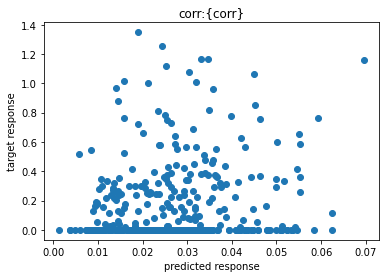

In [46]:
pred_resp_all = []
resp_all = []
for i in range(10):
    imgtsr = G.visualize(3*torch.randn(40,4096).cuda())
    pred_resp = score_images(VGG.features, model_scorer, layer, imgtsr, preprocessor=lambda x:x)
    resp = scorer.score_tsr_wgrad(imgtsr, B=40).cpu()
    del imgtsr
    pred_resp_all.append(pred_resp)
    resp_all.append(resp)
pred_resp = torch.cat(pred_resp_all,dim=0)
resp = torch.cat(resp_all,dim=0)

corr = np.corrcoef(pred_resp.numpy(),resp.numpy())[0,1]
plt.scatter(pred_resp.numpy(),resp.numpy())
plt.ylabel("target response")
plt.xlabel("predicted response")
plt.title("corr:{corr}")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


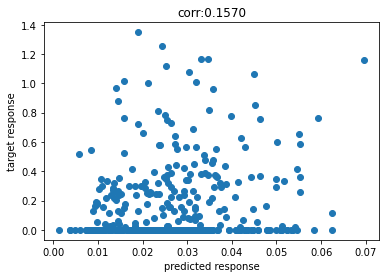

In [60]:
plt.scatter(pred_resp.numpy(),resp.numpy())
plt.ylabel("target response")
plt.xlabel("predicted response")
plt.title("corr:{:.4f}".format(corr))
plt.show()

In [17]:
import insilico_Exp_torch
insilico_Exp_torch.activation

{'score': tensor([0.0000, 0.2195, 0.3401, 0.1039, 0.0000, 0.0000, 0.4964, 0.0000, 0.0000,
         0.1605, 0.0000, 0.0000, 0.3008, 0.0650, 0.0000, 0.2334, 0.0361, 0.0953,
         0.1468, 0.0000, 0.0578, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3310,
         0.0000, 0.3218, 0.0000, 0.0000, 0.0000, 0.0540, 0.4187, 0.2629, 0.0000,
         0.0440, 0.0000, 0.0673, 0.1267], device='cuda:0')}

## Use Evolution Data to Learn Model

In [6]:
scorer = TorchScorer("resnet50")
scorer.select_unit(("resnet50", layer, 5, 2, 5), allow_grad=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Model Network
VGG = models.vgg16(pretrained=True)
VGG.requires_grad_(False).eval()
VGG.features.cuda()
# Multi-case modelling 
featFetcher = Corr_Feat_Machine()
featFetcher.register_hooks(VGG, ["conv2_2", "conv3_3","conv4_3", "conv5_3"], netname='vgg16', verbose=False)
featFetcher.init_corr()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Feature Correlator Destructed, Hooks deleted.


In [8]:
import cma
es = cma.CMAEvolutionStrategy(4096 * [0], 1)
for i in tqdm(range(150)):
    z = es.ask()
    z_arr = np.array(z)
    imgs = G.visualize(torch.tensor(z_arr).float().cuda())
    resp = scorer.score_tsr_wgrad(imgs, B=40)
    es.tell(z, (-resp).tolist())
    print("{} {}".format(resp.mean(),resp.std()))
    with torch.no_grad():
        VGG.features(imgs)
    del imgs
    featFetcher.update_corr(resp.cpu())

featFetcher.calc_corr()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

(14_w,28)-aCMA-ES (mu_w=8.1,w_1=21%) in dimension 4096 (seed=717555, Tue Sep 14 00:10:46 2021)
0.07857576012611389 0.22257688641548157


  1%|▌                                                                                 | 1/150 [00:00<02:14,  1.11it/s]

0.1252378672361374 0.26564347743988037


  1%|█                                                                                 | 2/150 [00:01<02:02,  1.21it/s]

0.2691727578639984 0.2711375653743744


  2%|█▋                                                                                | 3/150 [00:02<01:58,  1.24it/s]

0.27939411997795105 0.3521880507469177


  3%|██▏                                                                               | 4/150 [00:03<01:54,  1.27it/s]

0.47996607422828674 0.4630643427371979


  3%|██▋                                                                               | 5/150 [00:03<01:53,  1.28it/s]

0.3612600862979889 0.35316288471221924


  4%|███▎                                                                              | 6/150 [00:04<01:52,  1.28it/s]

0.3608727753162384 0.3803010582923889


  5%|███▊                                                                              | 7/150 [00:05<01:52,  1.27it/s]

0.34620097279548645 0.28982019424438477


  5%|████▎                                                                             | 8/150 [00:06<01:54,  1.25it/s]

0.5259716510772705 0.4486572742462158


  6%|████▉                                                                             | 9/150 [00:07<01:53,  1.25it/s]

0.5071187019348145 0.5388349294662476


  7%|█████▍                                                                           | 10/150 [00:08<01:53,  1.24it/s]

0.6384820938110352 0.5099920630455017


  7%|█████▉                                                                           | 11/150 [00:08<01:52,  1.23it/s]

0.6711952090263367 0.3779042661190033


  8%|██████▍                                                                          | 12/150 [00:09<01:50,  1.25it/s]

0.7169816493988037 0.48127129673957825


  9%|███████                                                                          | 13/150 [00:10<01:50,  1.24it/s]

0.842878520488739 0.4552898705005646


  9%|███████▌                                                                         | 14/150 [00:11<01:49,  1.24it/s]

0.9509758949279785 0.7547361850738525


 10%|████████                                                                         | 15/150 [00:12<01:49,  1.24it/s]

0.9407243728637695 0.6398053169250488


 11%|████████▋                                                                        | 16/150 [00:12<01:47,  1.25it/s]

1.1814838647842407 0.6113225817680359


 11%|█████████▏                                                                       | 17/150 [00:13<01:46,  1.25it/s]

1.2108696699142456 0.5791255235671997


 12%|█████████▋                                                                       | 18/150 [00:14<01:45,  1.25it/s]

1.4109734296798706 0.8877047896385193


 13%|██████████▎                                                                      | 19/150 [00:15<01:44,  1.25it/s]

1.3550363779067993 0.8191046118736267


 13%|██████████▊                                                                      | 20/150 [00:16<01:43,  1.25it/s]

1.7060078382492065 0.8345133066177368


 14%|███████████▎                                                                     | 21/150 [00:16<01:44,  1.24it/s]

2.1771416664123535 0.7222317457199097


 15%|███████████▉                                                                     | 22/150 [00:17<01:43,  1.24it/s]

2.046705722808838 0.7528042197227478


 15%|████████████▍                                                                    | 23/150 [00:18<01:43,  1.23it/s]

2.236992359161377 0.8692156672477722


 16%|████████████▉                                                                    | 24/150 [00:19<01:41,  1.24it/s]

2.3086178302764893 0.9173439145088196


 17%|█████████████▌                                                                   | 25/150 [00:20<01:38,  1.26it/s]

2.3295812606811523 0.8482118248939514


 17%|██████████████                                                                   | 26/150 [00:20<01:37,  1.28it/s]

2.636137008666992 0.9619026780128479


 18%|██████████████▌                                                                  | 27/150 [00:21<01:36,  1.28it/s]

2.6561150550842285 0.8295554518699646


 19%|███████████████                                                                  | 28/150 [00:22<01:35,  1.28it/s]

2.7860023975372314 0.8040176630020142


 19%|███████████████▋                                                                 | 29/150 [00:28<04:33,  2.26s/it]

3.297241449356079 1.0966134071350098


 20%|████████████████▏                                                                | 30/150 [00:28<03:37,  1.81s/it]

3.741023540496826 0.8097541928291321


 21%|████████████████▋                                                                | 31/150 [00:29<02:59,  1.51s/it]

3.7372851371765137 0.902149498462677


 21%|█████████████████▎                                                               | 32/150 [00:30<02:32,  1.29s/it]

3.813044548034668 0.7799808382987976


 22%|█████████████████▊                                                               | 33/150 [00:31<02:11,  1.13s/it]

3.733024835586548 0.8653072118759155


 23%|██████████████████▎                                                              | 34/150 [00:31<01:57,  1.02s/it]

4.053285121917725 0.7149186730384827


 23%|██████████████████▉                                                              | 35/150 [00:32<01:48,  1.06it/s]

4.011135101318359 1.0358424186706543


 24%|███████████████████▍                                                             | 36/150 [00:33<01:42,  1.11it/s]

4.00888729095459 1.004302978515625


 25%|███████████████████▉                                                             | 37/150 [00:34<01:36,  1.17it/s]

3.909954309463501 0.5626329183578491


 25%|████████████████████▌                                                            | 38/150 [00:35<01:33,  1.20it/s]

4.154038429260254 0.7729143500328064


 26%|█████████████████████                                                            | 39/150 [00:35<01:30,  1.22it/s]

4.607759952545166 0.9350687861442566


 27%|█████████████████████▌                                                           | 40/150 [00:36<01:29,  1.23it/s]

4.821038722991943 0.6284358501434326


 27%|██████████████████████▏                                                          | 41/150 [00:37<01:27,  1.24it/s]

4.951395034790039 0.9416046142578125


 28%|██████████████████████▋                                                          | 42/150 [00:38<01:26,  1.25it/s]

5.102943420410156 0.6790631413459778


 29%|███████████████████████▏                                                         | 43/150 [00:39<01:26,  1.24it/s]

5.041772365570068 0.8909612894058228


 29%|███████████████████████▊                                                         | 44/150 [00:39<01:24,  1.25it/s]

5.277100563049316 0.765417218208313


 30%|████████████████████████▎                                                        | 45/150 [00:40<01:23,  1.25it/s]

5.399139881134033 0.9768909215927124


 31%|████████████████████████▊                                                        | 46/150 [00:41<01:21,  1.27it/s]

5.795106887817383 0.9582504034042358


 31%|█████████████████████████▍                                                       | 47/150 [00:42<01:19,  1.29it/s]

5.893804550170898 0.9150172472000122


 32%|█████████████████████████▉                                                       | 48/150 [00:42<01:18,  1.29it/s]

5.913039207458496 0.8822616338729858


 33%|██████████████████████████▍                                                      | 49/150 [00:43<01:18,  1.29it/s]

5.782633304595947 1.0227327346801758


 33%|███████████████████████████                                                      | 50/150 [00:44<01:17,  1.28it/s]

6.068204879760742 0.7281070351600647


 34%|███████████████████████████▌                                                     | 51/150 [00:45<01:16,  1.29it/s]

6.060328960418701 1.29909348487854


 35%|████████████████████████████                                                     | 52/150 [00:45<01:15,  1.30it/s]

6.413421154022217 0.9382522702217102


 35%|████████████████████████████▌                                                    | 53/150 [00:46<01:14,  1.30it/s]

6.572718620300293 0.693034291267395


 36%|█████████████████████████████▏                                                   | 54/150 [00:47<01:14,  1.28it/s]

6.818807601928711 0.7950159907341003


 37%|█████████████████████████████▋                                                   | 55/150 [00:48<01:13,  1.30it/s]

6.767598628997803 0.837078869342804


 37%|██████████████████████████████▏                                                  | 56/150 [00:49<01:11,  1.31it/s]

7.005888938903809 0.7967857718467712


 38%|██████████████████████████████▊                                                  | 57/150 [00:54<03:20,  2.15s/it]

6.980493545532227 0.6228010058403015


 39%|███████████████████████████████▎                                                 | 58/150 [00:55<02:39,  1.73s/it]

6.722102165222168 0.7253273129463196


 39%|███████████████████████████████▊                                                 | 59/150 [00:55<02:11,  1.44s/it]

7.031723499298096 0.8176966905593872


 40%|████████████████████████████████▍                                                | 60/150 [00:56<01:51,  1.24s/it]

7.114564895629883 0.9419154524803162


 41%|████████████████████████████████▉                                                | 61/150 [00:57<01:38,  1.11s/it]

7.2790093421936035 0.7205295562744141


 41%|█████████████████████████████████▍                                               | 62/150 [00:58<01:29,  1.01s/it]

7.059298038482666 0.5747666358947754


 42%|██████████████████████████████████                                               | 63/150 [00:59<01:22,  1.05it/s]

7.342576503753662 0.675012469291687


 43%|██████████████████████████████████▌                                              | 64/150 [00:59<01:18,  1.10it/s]

7.1507439613342285 0.8545525670051575


 43%|███████████████████████████████████                                              | 65/150 [01:00<01:13,  1.15it/s]

7.355363368988037 0.6424607038497925


 44%|███████████████████████████████████▋                                             | 66/150 [01:01<01:11,  1.18it/s]

7.321699142456055 0.6213875412940979


 45%|████████████████████████████████████▏                                            | 67/150 [01:02<01:08,  1.22it/s]

7.538383960723877 0.851034939289093


 45%|████████████████████████████████████▋                                            | 68/150 [01:03<01:05,  1.25it/s]

7.265010833740234 0.7878212928771973


 46%|█████████████████████████████████████▎                                           | 69/150 [01:03<01:04,  1.25it/s]

7.325710296630859 1.0052675008773804


 47%|█████████████████████████████████████▊                                           | 70/150 [01:04<01:04,  1.24it/s]

7.490034580230713 0.7717841863632202


 47%|██████████████████████████████████████▎                                          | 71/150 [01:05<01:03,  1.24it/s]

7.404775619506836 0.6957700848579407


 48%|██████████████████████████████████████▉                                          | 72/150 [01:06<01:01,  1.26it/s]

7.564228534698486 0.6569244265556335


 49%|███████████████████████████████████████▍                                         | 73/150 [01:06<01:00,  1.28it/s]

7.721134185791016 0.4759501516819


 49%|███████████████████████████████████████▉                                         | 74/150 [01:07<00:59,  1.28it/s]

7.637962818145752 0.6304170489311218


 50%|████████████████████████████████████████▌                                        | 75/150 [01:08<00:59,  1.27it/s]

7.642271041870117 0.9594812393188477


 51%|█████████████████████████████████████████                                        | 76/150 [01:09<00:57,  1.29it/s]

7.661111354827881 0.7428967952728271


 51%|█████████████████████████████████████████▌                                       | 77/150 [01:10<00:56,  1.28it/s]

7.425528526306152 0.7683427333831787


 52%|██████████████████████████████████████████                                       | 78/150 [01:10<00:55,  1.29it/s]

7.786019802093506 0.5925202965736389


 53%|██████████████████████████████████████████▋                                      | 79/150 [01:11<00:54,  1.29it/s]

7.5802388191223145 0.7880858778953552


 53%|███████████████████████████████████████████▏                                     | 80/150 [01:12<00:54,  1.29it/s]

7.7048211097717285 0.8205273747444153


 54%|███████████████████████████████████████████▋                                     | 81/150 [01:13<00:53,  1.28it/s]

7.771897792816162 0.6122041940689087


 55%|████████████████████████████████████████████▎                                    | 82/150 [01:13<00:52,  1.29it/s]

7.55930233001709 0.7374048233032227


 55%|████████████████████████████████████████████▊                                    | 83/150 [01:14<00:52,  1.28it/s]

7.689758777618408 0.8039982914924622


 56%|█████████████████████████████████████████████▎                                   | 84/150 [01:15<00:52,  1.26it/s]

7.848013401031494 0.5532772541046143


 57%|█████████████████████████████████████████████▉                                   | 85/150 [01:20<02:20,  2.17s/it]

7.428961753845215 0.6879716515541077


 57%|██████████████████████████████████████████████▍                                  | 86/150 [01:21<01:51,  1.75s/it]

7.433859825134277 0.8406473398208618


 58%|██████████████████████████████████████████████▉                                  | 87/150 [01:22<01:32,  1.46s/it]

7.6037163734436035 0.8798619508743286


 59%|███████████████████████████████████████████████▌                                 | 88/150 [01:23<01:18,  1.27s/it]

7.5657124519348145 0.8644944429397583


 59%|████████████████████████████████████████████████                                 | 89/150 [01:24<01:08,  1.12s/it]

7.545859336853027 1.0756654739379883


 60%|████████████████████████████████████████████████▌                                | 90/150 [01:24<01:00,  1.01s/it]

7.663416385650635 0.836540937423706


 61%|█████████████████████████████████████████████████▏                               | 91/150 [01:25<00:56,  1.05it/s]

8.160431861877441 0.9569544196128845


 61%|█████████████████████████████████████████████████▋                               | 92/150 [01:26<00:52,  1.11it/s]

8.14013957977295 0.7597331404685974


 62%|██████████████████████████████████████████████████▏                              | 93/150 [01:27<00:49,  1.16it/s]

7.799151420593262 0.9552100300788879


 63%|██████████████████████████████████████████████████▊                              | 94/150 [01:28<00:47,  1.18it/s]

8.329904556274414 0.7262579798698425


 63%|███████████████████████████████████████████████████▎                             | 95/150 [01:28<00:45,  1.21it/s]

8.143192291259766 0.807198703289032


 64%|███████████████████████████████████████████████████▊                             | 96/150 [01:29<00:44,  1.20it/s]

8.235368728637695 0.7790347337722778


 65%|████████████████████████████████████████████████████▍                            | 97/150 [01:30<00:44,  1.20it/s]

8.395419120788574 0.8342151641845703


 65%|████████████████████████████████████████████████████▉                            | 98/150 [01:31<00:42,  1.23it/s]

8.305871963500977 0.7883169651031494


 66%|█████████████████████████████████████████████████████▍                           | 99/150 [01:32<00:40,  1.25it/s]

8.247819900512695 0.8667175769805908


 67%|█████████████████████████████████████████████████████▎                          | 100/150 [01:32<00:39,  1.27it/s]

8.494342803955078 0.8290177583694458


 67%|█████████████████████████████████████████████████████▊                          | 101/150 [01:33<00:38,  1.26it/s]

8.362462043762207 0.7189554572105408


 68%|██████████████████████████████████████████████████████▍                         | 102/150 [01:34<00:37,  1.28it/s]

8.698585510253906 0.7503333687782288


 69%|██████████████████████████████████████████████████████▉                         | 103/150 [01:35<00:36,  1.30it/s]

8.569766998291016 0.8877788186073303


 69%|███████████████████████████████████████████████████████▍                        | 104/150 [01:35<00:35,  1.30it/s]

8.68122673034668 0.7224293351173401


 70%|████████████████████████████████████████████████████████                        | 105/150 [01:36<00:34,  1.30it/s]

8.810392379760742 0.8273818492889404


 71%|████████████████████████████████████████████████████████▌                       | 106/150 [01:37<00:33,  1.30it/s]

8.741385459899902 0.6965889930725098


 71%|█████████████████████████████████████████████████████████                       | 107/150 [01:38<00:32,  1.31it/s]

8.588081359863281 1.1355961561203003


 72%|█████████████████████████████████████████████████████████▌                      | 108/150 [01:38<00:32,  1.31it/s]

8.59691047668457 1.0343948602676392


 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [01:39<00:31,  1.31it/s]

8.740985870361328 0.7928411960601807


 73%|██████████████████████████████████████████████████████████▋                     | 110/150 [01:40<00:30,  1.29it/s]

8.893163681030273 0.7432565093040466


 74%|███████████████████████████████████████████████████████████▏                    | 111/150 [01:41<00:30,  1.30it/s]

8.766124725341797 0.8571431636810303


 75%|███████████████████████████████████████████████████████████▋                    | 112/150 [01:41<00:29,  1.29it/s]

8.619865417480469 0.8677952289581299


 75%|████████████████████████████████████████████████████████████▎                   | 113/150 [01:47<01:21,  2.21s/it]

8.670317649841309 0.9111752510070801


 76%|████████████████████████████████████████████████████████████▊                   | 114/150 [01:48<01:04,  1.79s/it]

8.903661727905273 0.6381197571754456


 77%|█████████████████████████████████████████████████████████████▎                  | 115/150 [01:49<00:51,  1.48s/it]

8.603670120239258 0.846275806427002


 77%|█████████████████████████████████████████████████████████████▊                  | 116/150 [01:49<00:42,  1.26s/it]

8.814891815185547 0.8071084022521973


 78%|██████████████████████████████████████████████████████████████▍                 | 117/150 [01:50<00:36,  1.11s/it]

8.786365509033203 0.647441029548645


 79%|██████████████████████████████████████████████████████████████▉                 | 118/150 [01:51<00:32,  1.02s/it]

8.546343803405762 0.967394232749939


 79%|███████████████████████████████████████████████████████████████▍                | 119/150 [01:52<00:29,  1.06it/s]

8.80628490447998 0.7173966765403748


 80%|████████████████████████████████████████████████████████████████                | 120/150 [01:52<00:26,  1.13it/s]

8.662528038024902 1.0741167068481445


 81%|████████████████████████████████████████████████████████████████▌               | 121/150 [01:53<00:25,  1.15it/s]

8.919642448425293 0.8289440870285034


 81%|█████████████████████████████████████████████████████████████████               | 122/150 [01:54<00:23,  1.18it/s]

9.064971923828125 0.8362946510314941


 82%|█████████████████████████████████████████████████████████████████▌              | 123/150 [01:55<00:22,  1.21it/s]

8.746824264526367 0.8677470684051514


 83%|██████████████████████████████████████████████████████████████████▏             | 124/150 [01:56<00:21,  1.24it/s]

8.771587371826172 0.994427502155304


 83%|██████████████████████████████████████████████████████████████████▋             | 125/150 [01:56<00:19,  1.25it/s]

8.819711685180664 0.9390766024589539


 84%|███████████████████████████████████████████████████████████████████▏            | 126/150 [01:57<00:19,  1.20it/s]

9.211349487304688 0.5704978704452515


 85%|███████████████████████████████████████████████████████████████████▋            | 127/150 [01:58<00:19,  1.20it/s]

9.036216735839844 0.8241449594497681


 85%|████████████████████████████████████████████████████████████████████▎           | 128/150 [01:59<00:18,  1.21it/s]

9.38420581817627 0.9042428135871887


 86%|████████████████████████████████████████████████████████████████████▊           | 129/150 [02:00<00:16,  1.24it/s]

9.73298454284668 0.6119498610496521


 87%|█████████████████████████████████████████████████████████████████████▎          | 130/150 [02:01<00:16,  1.23it/s]

9.32697582244873 0.7778255343437195


 87%|█████████████████████████████████████████████████████████████████████▊          | 131/150 [02:01<00:15,  1.25it/s]

9.589591026306152 0.5248876214027405


 88%|██████████████████████████████████████████████████████████████████████▍         | 132/150 [02:02<00:14,  1.26it/s]

9.417998313903809 0.6918389797210693


 89%|██████████████████████████████████████████████████████████████████████▉         | 133/150 [02:03<00:13,  1.26it/s]

9.42817211151123 0.7821676135063171


 89%|███████████████████████████████████████████████████████████████████████▍        | 134/150 [02:04<00:12,  1.28it/s]

9.429948806762695 0.8022232055664062


 90%|████████████████████████████████████████████████████████████████████████        | 135/150 [02:05<00:12,  1.25it/s]

9.686929702758789 0.9629733562469482


 91%|████████████████████████████████████████████████████████████████████████▌       | 136/150 [02:05<00:11,  1.25it/s]

9.806777000427246 0.7282326221466064


 91%|█████████████████████████████████████████████████████████████████████████       | 137/150 [02:06<00:10,  1.24it/s]

9.657626152038574 0.6437035202980042


 92%|█████████████████████████████████████████████████████████████████████████▌      | 138/150 [02:07<00:09,  1.25it/s]

9.782644271850586 0.651511549949646


 93%|██████████████████████████████████████████████████████████████████████████▏     | 139/150 [02:08<00:08,  1.27it/s]

9.815011978149414 0.547455906867981


 93%|██████████████████████████████████████████████████████████████████████████▋     | 140/150 [02:08<00:07,  1.28it/s]

9.835113525390625 0.6535630226135254


 94%|███████████████████████████████████████████████████████████████████████████▏    | 141/150 [02:14<00:20,  2.24s/it]

9.82192611694336 0.6337026953697205


 95%|███████████████████████████████████████████████████████████████████████████▋    | 142/150 [02:15<00:14,  1.80s/it]

10.00864028930664 0.6406517028808594


 95%|████████████████████████████████████████████████████████████████████████████▎   | 143/150 [02:16<00:10,  1.51s/it]

10.10280990600586 0.6364752054214478


 96%|████████████████████████████████████████████████████████████████████████████▊   | 144/150 [02:16<00:07,  1.29s/it]

10.327391624450684 0.47238144278526306


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 145/150 [02:17<00:05,  1.13s/it]

10.168008804321289 0.5705749988555908


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 146/150 [02:18<00:04,  1.03s/it]

10.084059715270996 0.6282005906105042


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 147/150 [02:19<00:02,  1.04it/s]

9.976367950439453 0.70644211769104


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 148/150 [02:20<00:01,  1.10it/s]

9.947565078735352 0.5458572506904602


 99%|███████████████████████████████████████████████████████████████████████████████▍| 149/150 [02:20<00:00,  1.14it/s]

10.246428489685059 0.6886507868766785


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [02:21<00:00,  1.06it/s]


Sparsity after T threshold 0.381
NMF explained variance 0.328
Factor0 norm 24.66
Factor1 norm 27.44
Factor2 norm 23.28
Correlation to the corr coef tensor 0.600


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


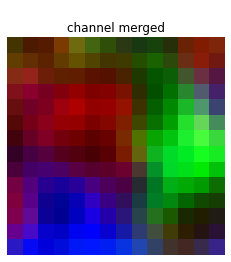

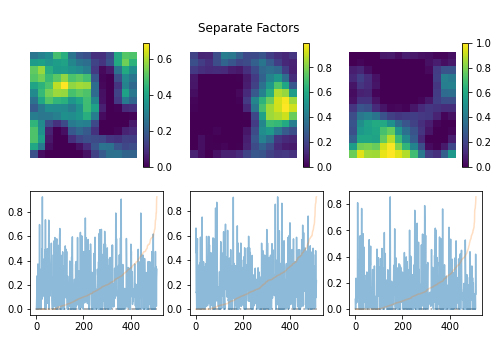

In [10]:
cctsr = featFetcher.cctsr['conv5_3'].numpy()
Ttsr = featFetcher.Ttsr['conv5_3'].numpy()
rect_mode = "Tthresh"; thresh = (None, 5)
bdr = 1; NF = 3
Hmat, Hmaps, ccfactor, FactStat = tsr_posneg_factorize(rectify_tsr(cctsr, rect_mode, thresh, Ttsr=Ttsr),
                     bdr=bdr, Nfactor=NF, show=True,)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


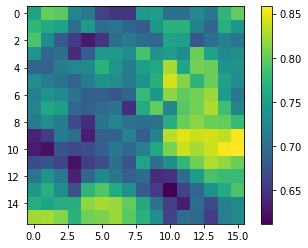

In [14]:
plt.imshow(np.abs(cctsr).max(axis=0))
plt.colorbar()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


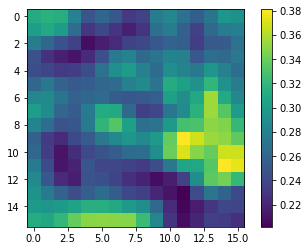

In [13]:
plt.imshow(np.abs(cctsr).mean(axis=0))
plt.colorbar()
plt.show()

In [15]:
layer = 'conv5_3'
netname = "vgg16"
cctsr_rect = rectify_tsr(cctsr, rect_mode, thresh, Ttsr=Ttsr)
model_scorer = CorrFeatScore()
model_scorer.register_hooks(VGG, layer, netname=netname)
# model_scorer.register_weights({layer: cctsr_rect})
model_scorer.register_weights({layer: cctsr})

Sparsity after T threshold 0.381


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 97.91it/s]


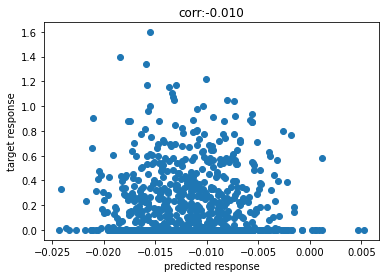

In [16]:
pred_resp_all = []
resp_all = []
for i in range(25):
    imgtsr = G.visualize(2*torch.randn(40,4096).cuda())
    pred_resp = score_images(VGG.features, model_scorer, layer, imgtsr, preprocessor=lambda x:x)
    resp = scorer.score_tsr_wgrad(imgtsr, B=40).cpu()
    del imgtsr
    pred_resp_all.append(pred_resp)
    resp_all.append(resp)
pred_resp = torch.cat(pred_resp_all,dim=0)
resp = torch.cat(resp_all,dim=0)

corr = np.corrcoef(pred_resp.numpy(),resp.numpy())[0,1]
plt.scatter(pred_resp.numpy(),resp.numpy())
plt.ylabel("target response")
plt.xlabel("predicted response")
plt.title("corr:{:.3f}".format(corr))
plt.show()

Seems using correlation of one trajectory to build model for the neuron does not generalize to images far from the peak. 



In [ ]:
imgN = len(imgfullpath_vect)
if type(score_vect) is not list:
    score_tsr = torch.tensor(score_vect).float()  # torchify the score vector
    rep_score = False
else:
    rep_score = True
csr = 0
pbar = tqdm(total=imgN)
while csr < imgN:
    cend = min(csr + batchsize, imgN)
    input_tsr = imgload_func(imgfullpath_vect[csr:cend])  #
    # input_tsr = loadimg_embed_preprocess(imgfullpath_vect[csr:cend], imgpix=imgpix, fullimgsz=(256, 256))
    # Pool through VGG
    with torch.no_grad():
        net(input_tsr.cuda()).cpu()
    if rep_score:
        featFetcher.update_corr_rep(score_vect[csr:cend])
    else:
        featFetcher.update_corr(score_tsr[csr:cend])
    # update bar!
    pbar.update(cend - csr)
    csr = cend
pbar.close()
featFetcher.calc_corr()